# Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.utils import shuffle
from skimage import exposure
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
%matplotlib inline
import seaborn as sns
from IPython.display import Audio, display
import pandas as pd

In [2]:
with open('../dataset/train.p', mode='rb') as f:
    train = pickle.load(f)
with open('../dataset/valid.p', mode='rb') as f:
    valid = pickle.load(f)
with open('../dataset/test.p', mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Dataset summary and exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

sign_classes, class_indices, class_counts = np.unique(
    y_train, return_index = True, return_counts = True)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes, "\n")
#print(sign_classes, "\n")
#print(class_indices, len(class_indices), "\n")
#print(class_counts, "\n")
#print(X_train.shape, y_train.shape)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43 



In [4]:
def allDone():
  display(Audio(url='http://hao.haolingsheng.com/ring/000/993/fc0fab7d5d00c2b345b4f57913df868b.mp3', autoplay=True))
## Insert whatever audio file you want above

### An exploratory visualization of the dataset

<Container object of 43 artists>

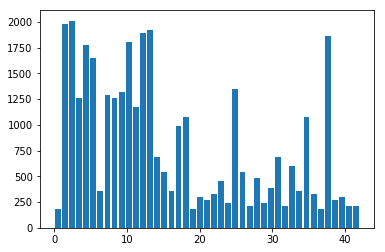

In [5]:
#plt.figure(figsize=(12, 6))
hist, bins = np.histogram(y_train, bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center')

In [11]:
class_names = pd.read_csv('../dataset/signnames.csv', sep=',')

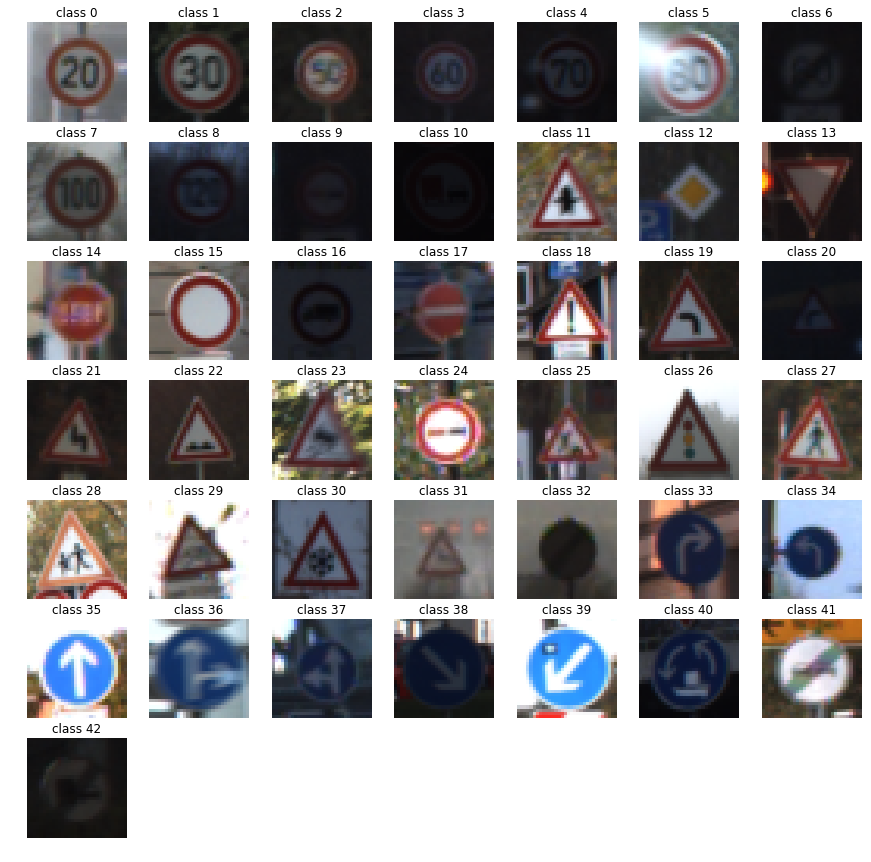

In [5]:
# Randomly plot 1 sign for each type
f = plt.figure(figsize=(15,15))
for idx in range(0,43): 
    random_indices = random.randint(class_indices[idx], class_indices[idx] + class_counts[idx])
    image = X_train[random_indices]
    plt.subplot(7, 7, idx+1) 
    plt.title('class %i' %idx)
    plt.axis('off')
    plt.imshow(image)

# Pre-process

In [6]:
def rgb2gray(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img

In [7]:
def histeq(img):
    img = cv2.equalizeHist(img)
    return img

In [8]:
def normal(img):
    img = (img - 128.) /128.
    #img = img.reshape((img.shape[0], img.shape[1], 1))
    return img

In [9]:
def reshapexx1(img):
    img = img.reshape((img.shape[0], img.shape[1], 1))
    return img

In [10]:
def rotation(img):
    rows, cols = img.shape[:2]
    m = cv2.getRotationMatrix2D((cols/2, rows/2),15, 1)
    res = cv2.warpAffine(img, m, (cols,rows))
    #res = res[:,:,np.newaxis]
    return res

In [35]:
def clahe(img):
    ahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    cl1 = ahe.apply(img)
    return img

In [12]:
def clahe_color(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return rgb

In [15]:
len(X_train)

34799

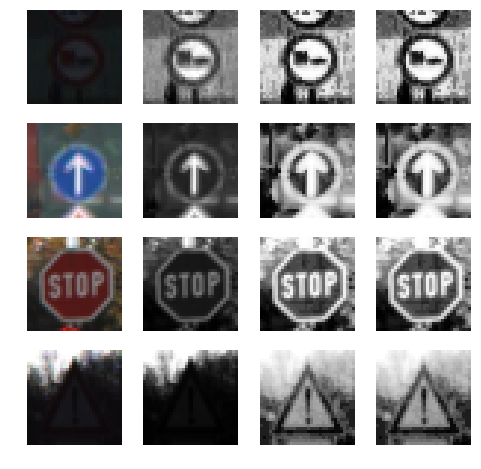

In [36]:
f = plt.figure(figsize=(8,8))

for i in range(4):
    img1 = X_train[np.random.randint(len(X_train))]
    plt.subplot(4,4,4*i+1)
    plt.axis('off')
    plt.imshow(img1)
    plt.subplot(4,4,4*i+2)
    plt.axis('off')
    img1 = rgb2gray(img1)
    plt.imshow(img1, cmap = 'gray')
    plt.subplot(4,4,4*i+3)
    plt.axis('off')
    img1 = histeq(img1)
    plt.imshow(img1, cmap = 'gray')
    plt.subplot(4,4,4*i+4)
    plt.axis('off')
    img1 = normal(img1)
    plt.imshow(img1, cmap = 'gray')

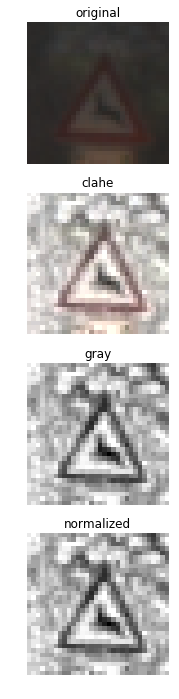

In [30]:
random_sample1 = X_train[222]
#img_gray1 = rgb2gray(random_sample1)
img_eq1 = clahe_color(random_sample1)
img_gray1 = rgb2gray(img_eq1)
img_norm1 = normal(img_gray1)
#img_rotated = rotation(img_norm)

#img_reshaped = reshapexx1(img_eq)
f00 = plt.figure(figsize=(12,12))
plt.subplot(4,1,1)
plt.axis('off')
plt.title('original')
plt.imshow(random_sample1)
plt.subplot(4,1,2)
plt.axis('off')
plt.title('clahe')
plt.imshow(img_eq1)
plt.subplot(4,1,3)
plt.axis('off')
plt.title('gray')
plt.imshow(img_gray1,cmap='gray')
plt.subplot(4,1,4)
plt.axis('off')
plt.title('normalized')
plt.imshow(img_norm1,cmap='gray')

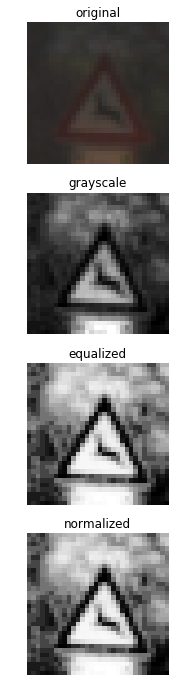

In [16]:
random_sample = X_train[222]
img_gray = rgb2gray(random_sample)
img_eq = histeq(img_gray)
img_norm = normal(img_eq)
#img_rotated = rotation(img_norm)

#img_reshaped = reshapexx1(img_eq)
f00 = plt.figure(figsize=(12,12))
plt.subplot(4,1,1)
plt.axis('off')
plt.title('original')
plt.imshow(random_sample)
plt.subplot(4,1,2)
plt.axis('off')
plt.title('grayscale')
plt.imshow(img_gray,cmap='gray')
plt.subplot(4,1,3)
plt.axis('off')
plt.title('equalized')
plt.imshow(img_eq,cmap='gray')
plt.subplot(4,1,4)
plt.axis('off')
plt.title('normalized')
plt.imshow(img_norm,cmap='gray')
#plt.subplot(1,5,5)
#plt.imshow(img_reshaped.reshape(32,32),cmap='gray')

#print(random_sample.shape, img_gray.shape,img_eq.shape, img_norm.shape, img_reshaped.shape)

In [33]:
def pipeline(img):
    img = rgb2gray(img)
    img =  clahe(img)
    img =  normal(img)
    img =  reshapexx1(img)
    return img

In [34]:
def pipeline_color(img):
    img = clahe_color(img)
    return img

In [35]:
def pipeline_he(img):
    img = rgb2gray(img)
    img =  histeq(img)
    img =  normal(img)
    img =  reshapexx1(img)
    return img

In [14]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = (img / 256.).astype(np.float32)
    img = (img - 128.) /128.
    img = img.reshape((img.shape[0], img.shape[1], 1))
    return(img)

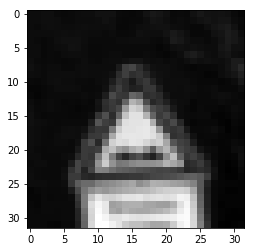

In [27]:
test = preprocess(X_train[4744])
test_he = pipeline_he(X_train[4744])
plt.imshow(test.reshape(32,32),cmap='gray')

# Architecture design

#### LeNet and its modified version for our project

Train, validate, and test the model

In [36]:
x_train = []
for i in range(n_train):
    x_train.append(pipeline_he(X_train[i]))

x_valid = []
for i in range(len(X_valid)):
    x_valid.append(pipeline_he(X_valid[i]))
    
x_test = []
for i in range(len(X_test)):
    x_test.append(pipeline_he(X_test[i]))

In [16]:
x_train_he = []
for i in range(n_train):
    x_train_he.append(pipeline(X_train[i]))

x_valid_he = []
for i in range(len(X_valid)):
    x_valid_he.append(pipeline(X_valid[i]))
    
x_test_he = []
for i in range(len(X_test)):
    x_test_he.append(pipeline(X_test[i]))

In [37]:
x_train, y_train = shuffle(x_train, y_train)

In [17]:
x_train_he, y_train = shuffle(x_train_he, y_train)

In [38]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    print("layer 1 shape:",conv1.get_shape())
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    print("layer 2 shape:",conv2.get_shape())
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    print("layer 3 shape:",fc1.get_shape())
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1    = tf.nn.dropout(fc1, keep_prob)
            
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    print("layer 4 shape:",fc2.get_shape())
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [39]:
def LeNet_modified(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
    #x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
    
    #x = tf.nn.bias_add(x, b2)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits

In [44]:
# Define training parameters
EPOCHS = 100
BATCH_SIZE = 128

# Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Learning rate
rate = 0.001
keep_prob = 0.85

In [45]:
logits = LeNet_modified(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

layer 1 shape: (?, 28, 28, 6)
layer2flat shape: (?, 400)
xflat shape: (?, 400)
x shape: (?, 800)


In [46]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [47]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(x_valid, y_valid)
        training_accuracy = evaluate(x_train, y_train)
        test_accuracy = evaluate(x_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        
    saver.save(sess, './lenet0')
    print("Model saved")
    #allDone()

Training...

EPOCH 1 ...
Validation Accuracy = 0.804
Training Accuracy = 0.863
Test Accuracy = 0.781

EPOCH 2 ...
Validation Accuracy = 0.877
Training Accuracy = 0.941
Test Accuracy = 0.849

EPOCH 3 ...
Validation Accuracy = 0.889
Training Accuracy = 0.963
Test Accuracy = 0.867

EPOCH 4 ...
Validation Accuracy = 0.909
Training Accuracy = 0.977
Test Accuracy = 0.886

EPOCH 5 ...
Validation Accuracy = 0.916
Training Accuracy = 0.983
Test Accuracy = 0.894

EPOCH 6 ...
Validation Accuracy = 0.914
Training Accuracy = 0.985
Test Accuracy = 0.891

EPOCH 7 ...
Validation Accuracy = 0.915
Training Accuracy = 0.988
Test Accuracy = 0.891

EPOCH 8 ...
Validation Accuracy = 0.917
Training Accuracy = 0.992
Test Accuracy = 0.908

EPOCH 9 ...
Validation Accuracy = 0.932
Training Accuracy = 0.994
Test Accuracy = 0.905

EPOCH 10 ...
Validation Accuracy = 0.920
Training Accuracy = 0.993
Test Accuracy = 0.902

EPOCH 11 ...
Validation Accuracy = 0.917
Training Accuracy = 0.996
Test Accuracy = 0.908

EPOCH 

EPOCH 92 ...
Validation Accuracy = 0.936
Training Accuracy = 0.999
Test Accuracy = 0.921

EPOCH 93 ...
Validation Accuracy = 0.944
Training Accuracy = 0.999
Test Accuracy = 0.924

EPOCH 94 ...
Validation Accuracy = 0.943
Training Accuracy = 1.000
Test Accuracy = 0.929

EPOCH 95 ...
Validation Accuracy = 0.943
Training Accuracy = 1.000
Test Accuracy = 0.927

EPOCH 96 ...
Validation Accuracy = 0.932
Training Accuracy = 0.999
Test Accuracy = 0.925

EPOCH 97 ...
Validation Accuracy = 0.927
Training Accuracy = 0.999
Test Accuracy = 0.920

EPOCH 98 ...
Validation Accuracy = 0.937
Training Accuracy = 0.999
Test Accuracy = 0.926

EPOCH 99 ...
Validation Accuracy = 0.944
Training Accuracy = 0.999
Test Accuracy = 0.925

EPOCH 100 ...
Validation Accuracy = 0.940
Training Accuracy = 1.000
Test Accuracy = 0.930

Model saved
